In [79]:
import pandas as pd
import numpy as np
import calendar as cal
import matplotlib.pyplot as plt

## Questions (suggestions)
 - what were the features of the bond?
 - why the bond was issued?
 - how much was authorized and how much was sold?
 - at what price was the bond originally sold and what was the price history on the secondary market?
 - when was the bond redeemed?

## Data format notes
 - PDF Readme on the dataframe's github [here](https://github.com/jepayne/US-Federal-Debt-Public/blob/master/Industrial-Suite/Documentation/ReadMe_Pub_20180910.pdf)
 - The order in which the categories are listed is not necessarily the same; some are switched to make the list read more logically

### BondList
 - Import id is not used
 - Category L* describes the category in level L*
 - Category L* ID is the numeric ID of the above
 - Issue IDs are the numeric ID of a bond within its category
 - L* ID is the bond's ID within level L* (therefore, L1 ID is the unique id for each bond because it is the highest category, so it is the index)
 - Very few of the Authorizing Act Date entries are actually in the raw data, they may need imputing from the Authorizing Act string - for now, if you want an "issuance date" of the security use the "First Issue Date" column

In [80]:
Bondh5 = pd.HDFStore("data/BondDF.h5", mode="r")
BondList = Bondh5["BondList"]
BondQuant = Bondh5["BondQuant"]
BondPrice = Bondh5["BondPrice"]
Bondh5.close()

In [81]:
# Helper functions

def get_cf_as_string(row):
  """
  Takes a row from the BondList frame and returns the a string indicating the month which the bond
  is scheduled.
  """
  
  for i in range(1, 13):
    if row[f"CF{str(i).zfill(2)}"] > 0: return cal.month_name[i]
  if row["Ambiguous"] > 0: return "Ambiguous"
  return "N/A"

def is_nan(value):
  """
  Utility to check if a value is nan
  """
  str_value = str(value)
  if str_value == "nan" or str_value == "NaT": return True


## Liberty & Victory Loans

 - [This concise article](https://www.federalreservehistory.org/essays/liberty-bonds#footnote1) gives a summary of the bonds
 - Bonds are conveniently classified under the level three category "Liberty Loan"
 - These bonds were used to fund World War I
 - The below cell isolates and prints information about the liberty loans from the BondList dataframe
 - Note: These are all par bonds, meaning their original price is equal to their face value.

In [82]:
#Define the liberty loans sub-dataframe
BondList.sort_values(by=["First Issue Date"], ascending=True, inplace=True)
liberty_loans = BondList.loc[(BondList['Category L3'] == "Liberty Loan")]
BondList.iloc[:, 0]

#Define a helper function to summarize a bond
def summarize_bond(bond_row):
  noi = bond_row["Treasury's Name Of Issue"] # noi：
  print(f"Bond #{bond_row['Issue L1 ID']}: {noi}{', issued ' + str(bond_row['First Issue Date']) if not is_nan(bond_row['First Issue Date']) else ''}")
  if is_nan(bond_row["Term Of Loan"]):
    print("   No further information")
    return bond_row
  print(f"   Term: {bond_row['Term Of Loan']}, Redeemable: {bond_row['Redeemable After Date']}, Payable: {bond_row['Payable Date']}")
  print(f"   Coupon: {bond_row['Coupon Rate']}, Frequency: {bond_row['Coupons Per Year']}/year, Scheduled Month: {get_cf_as_string(bond_row)}")
  print(f"   Is callable: {bond_row['Callable'] == 1.0}, Coin: {'Yes/Unspecified' if bond_row['Coin'] > 0 else 'No'}")
  print("---------------------------------------------------")
  return bond_row

#Uncomment to p rint a summary of all bonds labeled "Liberty Loan"
liberty_loans.apply(summarize_bond, axis=1)
print("Done") #Here so the cell output does not include the dataframe snippet

Bond #162: 1st Liberty Loan of 1917 (3.5%), issued 1917-06-30 00:00:00
   Term: 30 years, Redeemable: 1932-06-15 00:00:00, Payable: 1947-06-15 00:00:00
   Coupon: 3.5, Frequency: 2.0/year, Scheduled Month: June
   Is callable: True, Coin: Yes/Unspecified
---------------------------------------------------
Bond #166: 2nd Liberty Loan of 1917 (4%), issued 1917-10-31 00:00:00
   Term: 25 years, Redeemable: 1927-11-15 00:00:00, Payable: 1942-11-15 00:00:00
   Coupon: 4.0, Frequency: 2.0/year, Scheduled Month: May
   Is callable: True, Coin: Yes/Unspecified
---------------------------------------------------
Bond #168: 3rd Liberty Loan, issued 1918-05-31 00:00:00
   Term: 10 years, Redeemable: NaT, Payable: 1928-09-15 00:00:00
   Coupon: 4.25, Frequency: 2.0/year, Scheduled Month: March
   Is callable: False, Coin: Yes/Unspecified
---------------------------------------------------
Bond #169: 4th Liberty Loan, issued 1918-09-30 00:00:00
   Term: 20 years, Redeemable: 1933-10-15 00:00:00, Pa

In [83]:
#Change the pandas float format for printing
pd.options.display.float_format = '${:,.0f}'.format

#Helper formatting function for large sums of money
def big_dollars_format(x, pos):
    strx = str(x)
    if x >= 1e9:
        return f"${strx[0]}.{strx[1:4]}b"
    if x >= 1e8:
        return f"${strx[:3]}.{strx[3]}m"

#BondQuant_Transposed is months by bond, as opposed to bond by months
BondQuant_Transposed = BondQuant.transpose()
#define some important dates for context
join_ts = pd.Timestamp("1917-4-4")
armistice_ts = pd.Timestamp("1918-11-11")

def graph_public_for_bqs(bond_ids, axes=None, title=""):
    plt.clf()
    current_ax = axes
    lowest_number = 0
    closer_date = pd.Timestamp("1917-1-1")
    for id in bond_ids:
        series = BondQuant_Transposed.loc[(id, 'Public Holdings')]
        series = series[series.notna()]
        ax = series.plot.line(ax=current_ax, title=title,
                              legend=True, sharex=True, sharey=True, xlabel="Time",
                              ylabel="Quantity of Bonds", **{'marker': '.'})
        if current_ax == None: current_ax = ax
        lowest_number = min(lowest_number, series.min())
        closer_date = series.index[len(series)-1] if series.index[len(series)-1] > closer_date else closer_date
    ax.yaxis.set_major_formatter(big_dollars_format)
    ax.set_xlim(left=pd.Timestamp("1917-1-1"), right=closer_date + pd.DateOffset(months=2))
    ax.axvline(join_ts, color="black", alpha=0.25)
    ax.annotate("War declared", (join_ts, lowest_number), xycoords="data", rotation=90)
    ax.axvline(armistice_ts, color="blue", alpha=0.25)
    ax.annotate("Armistice", (armistice_ts, lowest_number), xycoords="data", rotation=90)
    ax.legend(labels=[str(x)[1:] for x in bond_ids])
    ax.get_legend().set_title("Color, Bond ID")
    
    plt.show()
    current_ax = None

#ax.plot(first_liberty_series.index.to_list()[17])

## 1st Liberty Loan of 1917
This loan was the first bond used to fund World War I. It also featured the option to convert it so that it would have a higher coupon rate. Thus, it was converted to having a coupon rate of 4% once and 4.25% twice in 1918. This loan had 4 million subscribers, and offered 2 billon dollars while 3.035 billion dollars were subscribed, but only 2 billion dollars were accepted. An average of 759 dollars were subscribed. 

Bond #162: 1st Liberty Loan of 1917 (3.5%), issued 1917-06-30 00:00:00
   Term: 30 years, Redeemable: 1932-06-15 00:00:00, Payable: 1947-06-15 00:00:00
   Coupon: 3.5, Frequency: 2.0/year, Scheduled Month: June
   Is callable: True, Coin: Yes/Unspecified
---------------------------------------------------
Bond #163: 1st Liberty Loan Converted to 4%, issued 1918-11-30 00:00:00
   Term: 30 years, Redeemable: 1932-06-15 00:00:00, Payable: 1947-06-15 00:00:00
   Coupon: 4.0, Frequency: 2.0/year, Scheduled Month: June
   Is callable: True, Coin: Yes/Unspecified
---------------------------------------------------
Bond #164: 1st Liberty Loan Converted to 4.25%, issued 1918-11-30 00:00:00
   Term: 30 years, Redeemable: 1932-06-15 00:00:00, Payable: 1947-06-15 00:00:00
   Coupon: 4.25, Frequency: 2.0/year, Scheduled Month: June
   Is callable: True, Coin: Yes/Unspecified
---------------------------------------------------
Bond #165: 1st Liberty Loan Second Converted to 4.25%, issued 1918-10-24 

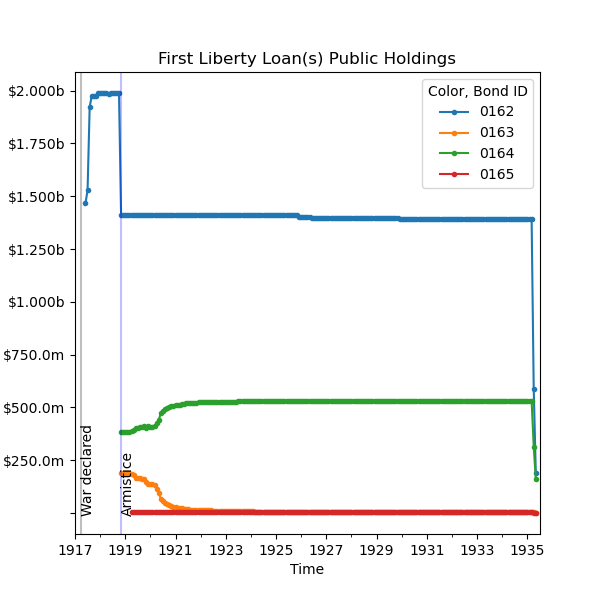

In [84]:
bond_ids = []
def summarize_only_first(bond_row):
    noi = bond_row["Treasury's Name Of Issue"]
    if "1st Liberty Loan" in noi:
        bond_ids.append(bond_row["Issue L1 ID"] + 20000)
        return summarize_bond(bond_row)
    return bond_row

liberty_loans.sort_index().apply(summarize_only_first, axis=1)

graph_public_for_bqs(bond_ids, title="First Liberty Loan(s) Public Holdings")

Here, it is shown that in 1917, the quantity outstanding was at 1,466,335,094, before increasing to nearly 2,000,000,000 and staying around that price before decreasing to around 1,400,000,000 in 1919, staying at around that amount before suddenly decreasing to around 189,928,800. 
The increase at the beginning can be attributed to many liberty bonds being sold at that time to finance WWI. As this resulted in more citizens and households deciding to own financial assets, the decrease soon after this in late 1919 can be attributed to the increase in discount rates used to curb the increase of bond prices, resulting in depreciation of bond prices. By 1935, most of the debt had already been paid back. 

## 2nd Liberty Loan
This loan was the second bond used to fund World War I. Much like the 1st bond, it had a convertable option. However, unlike the 1st loan, it could only be converted one time, and was converted to having a coupon rate of 4.25% once in 1918. This loan had 9.4 Million subscribers, and offered 3 billion dollars while 4.618 billion dollars were subscribed, but only 3.809 billion dollars were accepted. An average of 491 dollars were subscribed.

Bond #166: 2nd Liberty Loan of 1917 (4%), issued 1917-10-31 00:00:00
   Term: 25 years, Redeemable: 1927-11-15 00:00:00, Payable: 1942-11-15 00:00:00
   Coupon: 4.0, Frequency: 2.0/year, Scheduled Month: May
   Is callable: True, Coin: Yes/Unspecified
---------------------------------------------------
Bond #167: 2nd Liberty Loan Converted to 4.25%, issued 1918-11-30 00:00:00
   Term: 25 years, Redeemable: 1927-11-15 00:00:00, Payable: 1942-11-15 00:00:00
   Coupon: 4.25, Frequency: 2.0/year, Scheduled Month: May
   Is callable: True, Coin: Yes/Unspecified
---------------------------------------------------


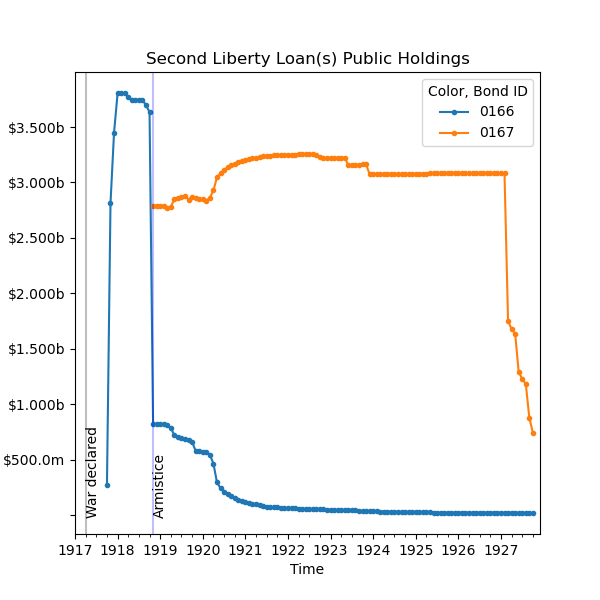

In [85]:
%matplotlib ipympl
bond_ids = []
def summarize_only_first(bond_row):
    noi = bond_row["Treasury's Name Of Issue"]
    if "2nd Liberty Loan" in noi:
        bond_ids.append(bond_row["Issue L1 ID"] + 20000)
        return summarize_bond(bond_row)
    return bond_row

liberty_loans.sort_index().apply(summarize_only_first, axis=1)

graph_public_for_bqs(bond_ids, title="Second Liberty Loan(s) Public Holdings")

## 3rd Liberty Loan
This loan was the third loan used to fund World War I. Unlike the first two loans, it didn't have a convertable option. This loan had 18.377 Million subscribers, and offered 3 billion dollars while 4.177 billion dollars were subscribed, and all 4.177 billion dollars were accepted. An average of 227 dollars were subscribed. 

Bond #168: 3rd Liberty Loan, issued 1918-05-31 00:00:00
   Term: 10 years, Redeemable: NaT, Payable: 1928-09-15 00:00:00
   Coupon: 4.25, Frequency: 2.0/year, Scheduled Month: March
   Is callable: False, Coin: Yes/Unspecified
---------------------------------------------------


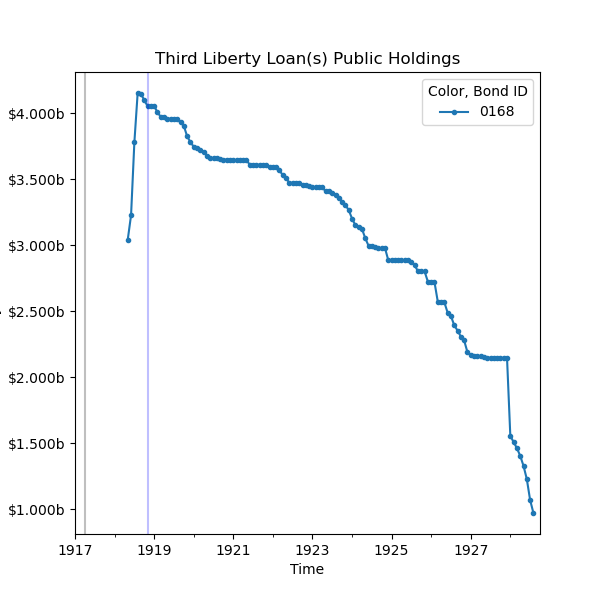

In [86]:
%matplotlib ipympl
bond_ids = []
def summarize_only_first(bond_row):
    noi = bond_row["Treasury's Name Of Issue"]
    if "3rd Liberty Loan" in noi:
        bond_ids.append(bond_row["Issue L1 ID"] + 20000)
        return summarize_bond(bond_row)
    return bond_row

liberty_loans.sort_index().apply(summarize_only_first, axis=1)

graph_public_for_bqs(bond_ids, title="Third Liberty Loan(s) Public Holdings")

## 4th Liberty Loan
This loan was the fourth loan used to fund World War I. Like the third loan, it didn't have a convertable option. This loan had 22.778 Million subscribers, and offered 6 billion dollars while 6.959 billion dollars were subscribed, and all 6.959 billion dollars were accepted.  An average of 306 dollars were subscribed. 

Bond #169: 4th Liberty Loan, issued 1918-09-30 00:00:00
   Term: 20 years, Redeemable: 1933-10-15 00:00:00, Payable: 1938-10-15 00:00:00
   Coupon: 4.25, Frequency: 2.0/year, Scheduled Month: April
   Is callable: True, Coin: Yes/Unspecified
---------------------------------------------------


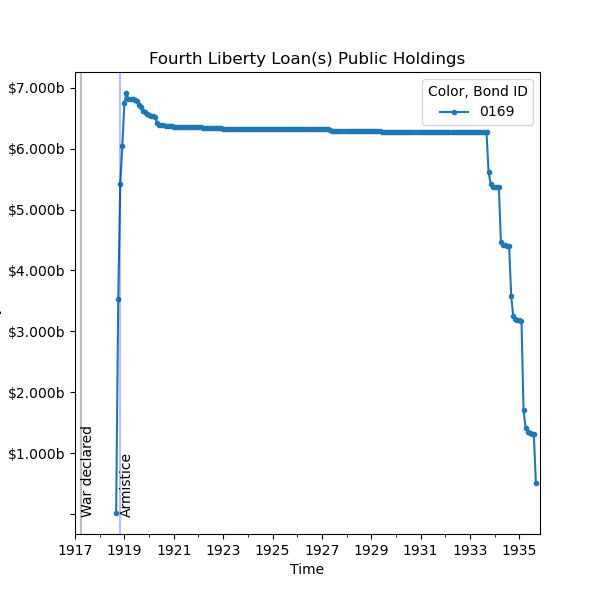

In [87]:
%matplotlib ipympl
bond_ids = []
def summarize_only_first(bond_row):
    noi = bond_row["Treasury's Name Of Issue"]
    if "4th Liberty Loan" in noi:
        bond_ids.append(bond_row["Issue L1 ID"] + 20000)
        return summarize_bond(bond_row)
    return bond_row

liberty_loans.sort_index().apply(summarize_only_first, axis=1)

graph_public_for_bqs(bond_ids, title="Fourth Liberty Loan(s) Public Holdings")

## Victory Loan
These were victory loans used after WWI. Like the third and fourth loans, they didn't have convertable options. These loan had 11.803 Million subscribers, and offered 4.5 billion dollars while 5.25 billion dollars were subscribed, and only 4.5 billion dollars were accepted. An average of 445 dollars were subscribed. 

Bond #170: Victory Liberty Loan (4 3/4%), issued 1919-05-20 00:00:00
   Term: 4 years, Redeemable: 1922-06-15 00:00:00, Payable: 1923-05-20 00:00:00
   Coupon: 4.75, Frequency: 2.0/year, Scheduled Month: June
   Is callable: True, Coin: Yes/Unspecified
---------------------------------------------------
Bond #171: Victory Liberty Loan (3 3/4%), issued 1919-05-20 00:00:00
   Term: 4 years, Redeemable: 1922-12-15 00:00:00, Payable: 1923-05-20 00:00:00
   Coupon: 3.75, Frequency: 2.0/year, Scheduled Month: June
   Is callable: True, Coin: Yes/Unspecified
---------------------------------------------------
Bond #176: Vic Lib Loan 4.75s, called, issued 1919-05-20 00:00:00
   No further information
Bond #177: Vic Lib Loan 4.75s, 1922-23, issued 1919-05-20 00:00:00
   No further information
Bond #178: Vic Lib Loan 4.75 of 1922-1923 and 3.75 of 1922-1923, issued 1919-05-20 00:00:00
   No further information


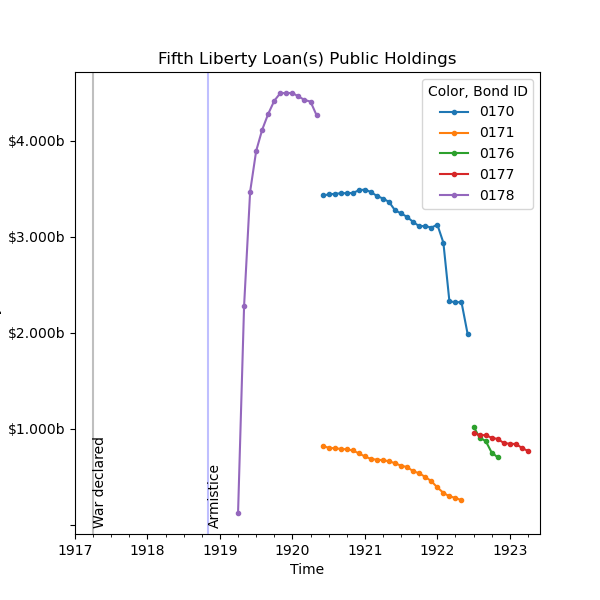

In [88]:
%matplotlib ipympl
bond_ids = []
def summarize_only_first(bond_row):
    noi = bond_row["Treasury's Name Of Issue"]
    if "Victory Liberty Loan" in noi or "Vic Lib Loan" in noi:
        bond_ids.append(bond_row["Issue L1 ID"] + 20000)
        return summarize_bond(bond_row)
    return bond_row

liberty_loans.sort_index().apply(summarize_only_first, axis=1)

graph_public_for_bqs(bond_ids, title="Fifth Liberty Loan(s) Public Holdings")

In [89]:
#Here's a quick utility function to get a breakdown of the bond in the bondquant dataset
#Note that this is better accomplished by the graph cells above
category_ids = [None, "Pre 1790 Domestic Debt", "Interest Bearing", "Non-interest bearing", "Other", "Asset"]

def get_ts_basic_info_formatted(l1_id, series_name):
    if series_name not in BondQuant_Transposed.loc[l1_id].index: return "<no column>"
    series = BondQuant_Transposed.loc[(l1_id, series_name)]
    series = series[series.notna()]
    if len(series) < 1: return "<nan>"
    return f"Starting at {'${:,.0f}'.format(series[0])}, ending at {'${:,.0f}'.format(series[len(series)-1])}"

def bond_quant_breakdown(l1_id):
    #first get the L1 ID level
    level = BondList.loc[l1_id, "Category L1 ID"]
    print(f"Kind: {category_ids[level]}")
    if level == 2:
        print(f"Total Outstanding: {get_ts_basic_info_formatted(l1_id, 'Total Outstanding')}")
        print(f"    Active: {get_ts_basic_info_formatted(l1_id, 'Active Outstanding')}")
        print(f"        Public: {get_ts_basic_info_formatted(l1_id, 'Public Holdings')}")
        print(f"            Coupon: {get_ts_basic_info_formatted(l1_id, 'Coupon')}")
        print(f"            Registered: {get_ts_basic_info_formatted(l1_id, 'Registered')}")
        print(f"        Intra gov: {get_ts_basic_info_formatted(l1_id, 'Intra Government Holdings')}")
        print(f"    Matured: {get_ts_basic_info_formatted(l1_id, 'Matured Outstanding')}")
        print(f"    Called: {get_ts_basic_info_formatted(l1_id, 'Called Outstanding')}")

bond_quant_breakdown(20162)

Kind: Interest Bearing
Total Outstanding: Starting at $1,466,335,094, ending at $189,928,800
    Active: Starting at $1,466,335,094, ending at $189,928,800
        Public: Starting at $1,466,335,094, ending at $189,928,800
            Coupon: Starting at $1,155,779,600, ending at $1,151,418,250
            Registered: Starting at $257,788,300, ending at $262,148,400
        Intra gov: <nan>
    Matured: <nan>
    Called: <no column>


/var/folders/3f/77w9tyf13fvfq2c4rg1tp9x40000gn/T/ipykernel_67066/1419256315.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return f"Starting at {'${:,.0f}'.format(series[0])}, ending at {'${:,.0f}'.format(series[len(series)-1])}"


['Active Outstanding']
['Public Holdings']
['Coupon', 'Registered']
['Coupon', 'Registered']


/var/folders/3f/77w9tyf13fvfq2c4rg1tp9x40000gn/T/ipykernel_67066/2555570339.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  to_append.append(series[0])


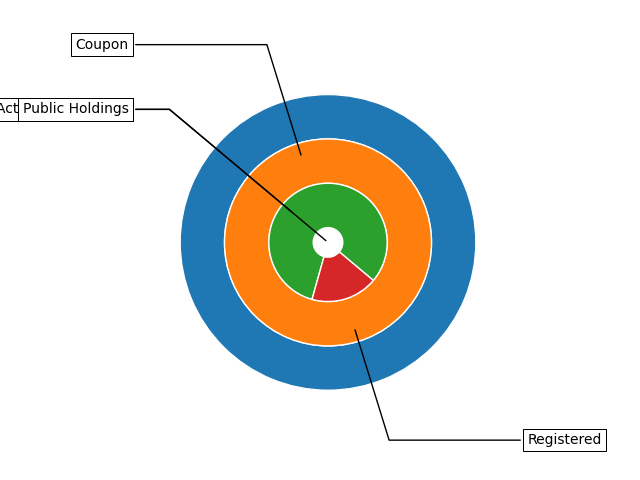

In [90]:
#Experiment: pie chart of a bond's status at a given point in time (the first year that BondQuant
#has records from the bond). The plot's labels do not work correctly at the moment (they overlap
#each other), but it is getting close. The idea is to have a slider so that you can adjust the year
#that you are viewing, to get a good glimpse into the history of the bond.
#note that this is NOT currently a part of the bond biography, just something cool that might be
#used in the actual biography later.
from anytree import Node
bond_id = 20162
size = 0.3

total = Node("Total Outstanding")
active_outstanding = Node("Active Outstanding", parent=total)
public_holdings = Node("Public Holdings", parent=active_outstanding)
Node("Coupon", parent=public_holdings)
Node("Registered", parent=public_holdings)
Node("Intra Government Holdings", parent=active_outstanding)
Node("Matured Outstanding", parent=total)
Node("Called Outstanding", parent=total)

resulting_pie = []
def add_layer(children):
    to_append = []
    texts = []
    for child in children:
        if child.name not in BondQuant_Transposed.loc[bond_id].index: continue
        series = BondQuant_Transposed.loc[(bond_id, child.name)]
        series = series[series.notna()]
        if len(series) < 1: continue # no data
        to_append.append(series[0])
        texts.append(child.name)
        if len(child.children) > 0: add_layer(child.children)
    resulting_pie.append((to_append, texts))
add_layer(total.children)
resulting_pie.reverse()

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=100, va="center")

def get_text_from_ij(i, j):
    current_arr = total.children
    for k in range(i-1): current_arr = current_arr[0]
    print(current_arr)
    return current_arr[j].name

fig, ax = plt.subplots()
i = 0
for numbers, labels in resulting_pie:
    wedges, texts = ax.pie(numbers, radius=1-(i*size), wedgeprops=dict(width=size, edgecolor='w'), startangle=-40)
    for j, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        print(labels)
        ax.annotate(labels[j], xy=(x*(i*size), y*(i*size)), xytext=(1.35*np.sign(x), 1.4*y), horizontalalignment=horizontalalignment, **kw)

    i+=1
plt.show()

/var/folders/3f/77w9tyf13fvfq2c4rg1tp9x40000gn/T/ipykernel_67066/287412477.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  to_append.append(series[0])


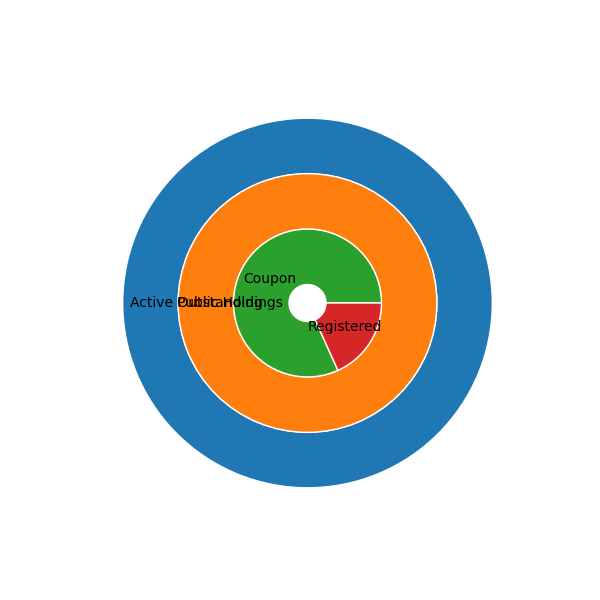

In [91]:
#Same as the cell above, using a different labeling system.
from anytree import Node
bond_id = 20162
size = 0.3

total = Node("Total Outstanding")
active_outstanding = Node("Active Outstanding", parent=total)
public_holdings = Node("Public Holdings", parent=active_outstanding)
Node("Coupon", parent=public_holdings)
Node("Registered", parent=public_holdings)
Node("Intra Government Holdings", parent=active_outstanding)
Node("Matured Outstanding", parent=total)
Node("Called Outstanding", parent=total)

resulting_pie = []
def add_layer(children):
    to_append = []
    texts = []
    for child in children:
        if child.name not in BondQuant_Transposed.loc[bond_id].index: continue
        series = BondQuant_Transposed.loc[(bond_id, child.name)]
        series = series[series.notna()]
        if len(series) < 1: continue # no data
        to_append.append(series[0])
        texts.append(child.name)
        if len(child.children) > 0: add_layer(child.children)
    resulting_pie.append((to_append, texts))
add_layer(total.children)
resulting_pie.reverse()

def get_text_from_ij(i, j):
    current_arr = total.children
    for k in range(i-1): current_arr = current_arr[0]
    print(current_arr)
    return current_arr[j].name

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
i = 0
j = 0
def pct_func(labels):
    global j
    j+=1
    return labels[j-1]
for numbers, labels in resulting_pie:
    ax.pie(numbers, radius=1-(i*size), wedgeprops=dict(width=size, edgecolor='w'), autopct=lambda pct: pct_func(labels))
    i+=1
    j = 0
plt.show()